### Import libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Find the number of sequences

In [18]:
'''
import pathlib
vir_path = pathlib.Path('./sequences/edwards/virus/')
host_path = pathlib.Path('./sequences/edwards/host/')
vir_count = 0
host_count = 0
for vir_file in vir_path.iterdir():
    vir_count += 1
for host_file in host_path.iterdir():
    host_count += 1

print(f'virus files: {vir_count}')
print(f'host files: {host_count}')
print(f'paired files: {vir_count * host_count}')
'''

"\nimport pathlib\nvir_path = pathlib.Path('./sequences/edwards/virus/')\nhost_path = pathlib.Path('./sequences/edwards/host/')\nvir_count = 0\nhost_count = 0\nfor vir_file in vir_path.iterdir():\n    vir_count += 1\nfor host_file in host_path.iterdir():\n    host_count += 1\n\nprint(f'virus files: {vir_count}')\nprint(f'host files: {host_count}')\nprint(f'paired files: {vir_count * host_count}')\n"

## Importing the dataset

### Merge the datasets

In [19]:
import pathlib
from functools import reduce

features_path = pathlib.Path('./features/')
dfs = [pd.read_csv(feat_file, sep='\t', header=0) 
                    for feat_file in features_path.iterdir()]
final_df = reduce(lambda left,right: 
                pd.merge(left,right,
                on=["#virus", "bacteria"],how="outer"), dfs)
final_df.shape

(2213180, 11)

## Replace the column names

In [20]:
col_names = ['virus', 'host']
col_names += [file.stem for file in features_path.iterdir()]
final_df.columns = col_names
final_df.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish
0,NC_010363,NC_008527,60.8,NaN,0.021973,NaN,0.002122,0.398421,0.382144,NaN,-1.33553
1,NC_010363,NC_002662,59.0,NaN,0.016709,NaN,0.001929,0.397773,0.377498,NaN,-1.33035
2,NC_010363,NC_017949,59.0,NaN,0.020818,NaN,0.002088,0.396969,0.379686,NaN,-1.33341
3,NC_010363,NC_017492,59.0,NaN,0.022209,NaN,0.002131,0.396148,0.380930,NaN,-1.33767
4,NC_010363,NC_009004,59.0,NaN,0.020871,NaN,0.002088,0.397095,0.379834,NaN,-1.33341


## Handle missing values

### Check for missing values

In [21]:
check_rows = final_df[~final_df.isnull().any(axis=1)]
check_rows.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish
3611,NC_011357,NC_012731,670.0,1.0,0.067620,2.0,0.002660,0.468791,0.410775,1.0,-1.38249
4182,NC_004585,NC_008022,22561.0,2.0,0.001751,14364.0,0.000713,0.285006,0.232619,1.0,-1.33040
4183,NC_004585,NC_008021,22561.0,2.0,0.002832,10850.0,0.000736,0.288697,0.235694,2.0,-1.33668
4187,NC_004585,NC_002737,12311.0,2.0,0.002570,6765.0,0.000741,0.290344,0.237060,2.0,-1.34749
4190,NC_004585,NC_020540,4621.0,3.0,0.002453,5271.0,0.000749,0.290872,0.237612,1.0,-1.36364


In [22]:
check_rows.shape

(469, 11)

### Check number of missing values

In [23]:
final_df.isna().sum()

virus                           0
host                            0
blastn                    1925573
crisprdetect-2mismatch    2212430
gc_content                      0
k25                       2154290
k6-chebyshev                    0
k6-kendalltau                   0
k6-manhattan                    0
piler-2mismatch           2212592
wish                            0
dtype: int64

In [24]:
final_df.notnull().sum()

virus                     2213180
host                      2213180
blastn                     287607
crisprdetect-2mismatch        750
gc_content                2213180
k25                         58890
k6-chebyshev              2213180
k6-kendalltau             2213180
k6-manhattan              2213180
piler-2mismatch               588
wish                      2213180
dtype: int64

### Fill missing values (according to promoter's suggestions)

In [25]:
final_df['blastn'].fillna(0, inplace=True)
final_df['crisprdetect-2mismatch'].fillna(0, inplace=True)
final_df['k25'].fillna(0, inplace=True)
final_df['piler-2mismatch'].fillna(0, inplace=True)

In [26]:
final_df.isna().sum()

virus                     0
host                      0
blastn                    0
crisprdetect-2mismatch    0
gc_content                0
k25                       0
k6-chebyshev              0
k6-kendalltau             0
k6-manhattan              0
piler-2mismatch           0
wish                      0
dtype: int64

## Find labels (which viruses infect which hosts in nature)

### Load in the taxonomy JSONs

In [27]:
import json
import pathlib

orgs = {}
for file in pathlib.Path('./taxonomy/').iterdir():
    with open(file, 'r') as open_file:
        orgs[file.stem] = json.load(open_file)
        
orgs.keys()

dict_keys(['host', 'virus'])

### Find groups for LeaveOneGroupOut

### Bacteria-based

In [28]:
'''
final_df['group'] = final_df.apply(lambda row: 
                    orgs['host'][row['host']]['lineage_names'][-3], axis=1)
pd.unique(final_df['group'])
'''

"\nfinal_df['group'] = final_df.apply(lambda row: \n                    orgs['host'][row['host']]['lineage_names'][-3], axis=1)\npd.unique(final_df['group'])\n"

### Virus-based

In [29]:
final_df['group'] = final_df.apply(lambda row: 
                    orgs['virus'][row['virus']]['host']['lineage_names'][-3], axis=1)

In [30]:
final_df['group'].value_counts()

Enterobacteriaceae                                   569489
Pseudomonadaceae                                     251007
Staphylococcaceae                                    199726
Streptococcaceae                                     188930
Bacillaceae                                          140348
Burkholderiaceae                                     113358
Vibrionaceae                                          94465
Propionibacteriaceae                                  59378
Mycobacteriaceae                                      59378
Xanthomonadaceae                                      48582
Listeriaceae                                          43184
Lactobacillaceae                                      43184
Clostridiaceae                                        35087
Enterococcaceae                                       35087
Aeromonadaceae                                        32388
Nocardiaceae                                          26990
Moraxellaceae                           

In [31]:
len(pd.unique(final_df['group']))

48

In [32]:
final_df.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae


<AxesSubplot:ylabel='group'>

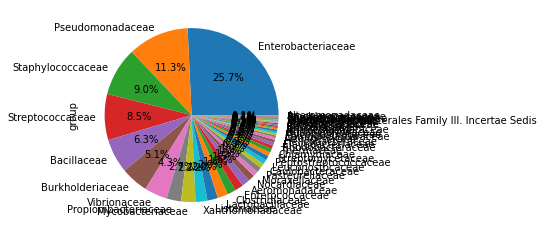

In [33]:
final_df['group'].value_counts().plot(kind="pie", autopct="%1.1f%%")

### Make 'group' parameter categorical – optimalization

In [34]:
final_df['group'].dtype

dtype('O')

In [35]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2213180 entries, 0 to 2213179
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   virus                   object 
 1   host                    object 
 2   blastn                  float64
 3   crisprdetect-2mismatch  float64
 4   gc_content              float64
 5   k25                     float64
 6   k6-chebyshev            float64
 7   k6-kendalltau           float64
 8   k6-manhattan            float64
 9   piler-2mismatch         float64
 10  wish                    float64
 11  group                   object 
dtypes: float64(9), object(3)
memory usage: 219.5+ MB


In [36]:
final_df['group'] = pd.Categorical(final_df['group'])
final_df['group'].dtype

CategoricalDtype(categories=['', 'Acholeplasmataceae', 'Aeromonadaceae', 'Alcaligenaceae',
                  'Alteromonadaceae', 'Bacillaceae', 'Bacteroidaceae',
                  'Bdellovibrionaceae', 'Brucellaceae', 'Burkholderiaceae',
                  'Campylobacteraceae', 'Caulobacteraceae', 'Chlamydiaceae',
                  'Clostridiaceae', 'Comamonadaceae', 'Corynebacteriaceae',
                  'Enterobacteriaceae', 'Enterococcaceae', 'Flavobacteriaceae',
                  'Helicobacteraceae', 'Lactobacillaceae', 'Leuconostocaceae',
                  'Listeriaceae', 'Microbacteriaceae', 'Moraxellaceae',
                  'Mycobacteriaceae', 'Mycoplasmataceae', 'Myxococcaceae',
                  'Nocardiaceae', 'Nostocaceae', 'Pasteurellaceae',
                  'Peptostreptococcaceae', 'Prochlorococcaceae',
                  'Propionibacteriaceae', 'Pseudomonadaceae', 'Rhizobiaceae',
                  'Rhodobacteraceae', 'Rhodospirillaceae', 'Rhodothermaceae',
              

NOTE: there are hosts without designated families

In [37]:
final_df[final_df['group'] == '']

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group
189108,NC_008562,NC_011729,1936.0,0.0,0.073441,50.0,0.003370,0.851879,0.639265,0.0,-1.43287,
189109,NC_008562,NC_010296,1930.0,0.0,0.036224,1431.0,0.002731,0.891840,0.601082,0.0,-1.44261,
189110,NC_008562,NC_016640,1159.0,0.0,0.023027,50.0,0.002908,0.864091,0.557508,0.0,-1.44114,
189111,NC_008562,NC_019753,801.0,0.0,0.057910,2.0,0.002481,0.797970,0.577121,0.0,-1.42135,
189112,NC_008562,NC_014501,720.0,0.0,0.057305,6.0,0.003333,0.830270,0.592474,0.0,-1.42505,
...,...,...,...,...,...,...,...,...,...,...,...,...
905267,NC_008562,NC_018417,0.0,0.0,0.314027,0.0,0.048148,0.767260,1.275939,0.0,-1.39383,
905268,NC_008562,NC_018415,0.0,0.0,0.317681,0.0,0.053895,0.757731,1.293647,0.0,-1.39432,
905269,NC_008562,NC_018416,0.0,0.0,0.317754,0.0,0.050627,0.765630,1.289442,0.0,-1.39417,
905270,NC_008562,NC_018414,0.0,0.0,0.319773,0.0,0.050478,0.763087,1.298034,0.0,-1.39409,


In [43]:
final_df['group_code'] = final_df['group'].cat.codes
final_df['group_code'] = pd.Categorical(final_df['group_code'])
final_df['group_code'].value_counts()

16    569489
34    251007
40    199726
41    188930
5     140348
9     113358
46     94465
25     59378
33     59378
47     48582
22     43184
20     43184
17     35087
13     35087
2      32388
28     26990
30     21592
24     21592
21     18893
11     18893
31     18893
42     16194
12     16194
43     13495
36     13495
18     10796
19     10796
3       8097
26      8097
10      8097
7       8097
6       5398
35      5398
8       5398
1       5398
23      5398
32      2699
29      2699
27      2699
37      2699
38      2699
39      2699
4       2699
14      2699
44      2699
45      2699
15      2699
0       2699
Name: group_code, dtype: int64

### Species-based labels

In [39]:
final_df['y'] = final_df.apply(lambda row: 
                    1 if orgs['host'][row['host']]['lineage_names'][-1] == 
                    orgs['virus'][row['virus']]['host']['lineage_names'][-1] 
                    else 0, axis=1)

In [40]:
final_df['y'].value_counts()

0    2196423
1      16757
Name: y, dtype: int64

In [15]:
final_df[final_df['y'] == 1]['group'].value_counts()

Enterobacteriaceae                                   8419
Staphylococcaceae                                    3342
Pseudomonadaceae                                     1012
Streptococcaceae                                      782
Listeriaceae                                          624
Bacillaceae                                           454
Vibrionaceae                                          436
Burkholderiaceae                                      342
Helicobacteraceae                                     212
Propionibacteriaceae                                  211
Mycobacteriaceae                                      156
Moraxellaceae                                         113
Lactobacillaceae                                       74
Xanthomonadaceae                                       71
Enterococcaceae                                        64
Chlamydiaceae                                          64
Peptostreptococcaceae                                  49
Clostridiaceae

In [44]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2213180 entries, 0 to 2213179
Data columns (total 14 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   virus                   object  
 1   host                    object  
 2   blastn                  float64 
 3   crisprdetect-2mismatch  float64 
 4   gc_content              float64 
 5   k25                     float64 
 6   k6-chebyshev            float64 
 7   k6-kendalltau           float64 
 8   k6-manhattan            float64 
 9   piler-2mismatch         float64 
 10  wish                    float64 
 11  group                   category
 12  group_code              category
 13  y                       int64   
dtypes: category(2), float64(9), int64(1), object(2)
memory usage: 223.7+ MB


## Save the dataframe to files

In [45]:
final_df.to_csv('main_df.csv',index=False)
final_df.to_pickle('./main_df.pkl')